# Predicting Heart Disease based on Medical Features

#### Author: Henning Heyen

Welcome to this notebook :)

This tutorial demonstrates the full machine learning pipeline and introduces fundamental concepts of a classification problem. The task is to predict whether or not a patient has a heart disease based on medical features. The dataset is taken from a [Kaggle challenge](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction). 

The notebook touches upon the following:

1. **Previous Work** that has been done on the same dataset including the literature and Kaggle.
2. **Exploratory data analysis** to get some insights about the dataset (characteristics and challenges)
3. **Preprocessing** including feature scaling, encoding and outlier handling. 
4. **Task and Evaluation**, i.e. choosing the right metric for the underlying problem.
5. **Design and build an ML system** using a flexible pipeline function. 
6. **Experimental analysis (performance & scalability)** by varying scaling and encoding techniques.
7. **Ethical considerations** with special focus on interpretability and biases.
8. **Sustainable development relevance & impact** with respect to the UN 2030 Sustainablity Goals.

# Table of Contents

[1 Previous Work](#1)

[2 Exploratory data analysis](#2)

[2.1 Characteristics of the dataset and trends](#2.1)

[2.2 Challenges with the dataset (missing values, outliers, imbalanced classes, biases)](#2.2)

[3 Preprocessing](#3)

[4 Task and evaluation](#4)

[5 Design and build an ML system](#5)

[6 Experimental analysis (performance & scalability)](#6)

[7 Ethical considerations](#7)

[8 Sustainable development relevance & impact](#8)

[9 References](#9)

In [1]:
# All imports
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

<a id='1'></a>
## 1 Previous work

**Introduction to the Dataset and the problem**

The dataset we are working on was taken from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) [Fedesoriano]. The data is tabular and consists of 11 medical features. The goal is to predict whether or not patients have a heart disease (or cardiovascular disease). The dataset set comes with a binary label which makes the problem a standard supervised classification problem.  

According to WHO, "cardiovascular diseases (CVDs) are the leading cause of death globally, taking an estimated 17.9 million lives in 2019, 32% of all deaths worldwide"[WHO]. "Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol"[WHO]. 

Therefore there is great potential in a predictive machine learning model to prevent heart diseases. The dataset consists of a combination of five heart disease datasets over 11 common features. All five datasets can found under the Index of heart disease datasets from UCI Machine Learning Repository [UCI1]. An overview of the combined datasets follows: 


**Datasets**:
- Cleveland: 303 observations
- Hungarian: 294 observations
- Switzerland: 123 observations
- Long Beach VA: 200 observations
- Stalog (Heart) Data Set: 270 observations  
  
Total: 1190 observations  
Duplicated: 272 observations  
Final dataset: 918 observations  

----

**Related Work**

**Literature**:  

To the best of my knowledge, the best results from the literature were achieved by [Alotaibi]. The code is not publically available. Note that in [Alotaibi] only the Cleveland dataset was used whereas this notebook uses the full dataset. According to [Alotaibi], effective feature selection and cross validation have lead to incresed accuracy as compared to other result on the same or similar dataset [Bashir], [Ekız]. [Alotaibi] uses standard Machine Learning models suited for classification problems. Here is an overview of the performance. Note that *This Study* refers to [Alotaibi] and the metric used is accuracy. 

![performance](images/performance.png)

We will try similar models, however, instead of soley accuracy, recall is taken into account as well because the main objective should be to minimize the number of false negatives (predicted no heart disease while patient actually has one) which is captured by recall. More on that in the Task and Evaluation part. 

**Kaggle Notebooks**:  

- Some contributers to Kaggle were uploading their notebooks. The best results I found were from @tanmay111999 ([Link](https://www.kaggle.com/code/tanmay111999/heart-failure-prediction-cv-score-90-5-models) to notebook). An overview of the results are shown below. 

<img src="images/performance3.png" alt="performance3" width="400"/>

**Contributions**:

Let me stress the novelty of this notebook compared to what was done before:
- Obviously Exploratory Data Analysis was done before but I try to be more illustrative, conceice and complete than others. Additionally I try to comment and interpret the analysis in much more detail than others.
- A preprocess pipeline is provided. With that various encoding techniques for the categorical variables, different data scaling techniques and feature selection can be applied in a super flexible and comparable manner. 
- The machine learning pipeline is highly flexible and can be extended by any classifier that follows the sklearn API.
- As mentioned above both accuracy and recall is taken into account
- Experiments using SVM. I am leveraging SVM using a polynomial kernel and preprocess the data using Principal Component analysis and cross validate the results.
- I am proposing a second model using Logistic Regression to output probabilities rather than 1 or 0. This way the model becomes more interpretable as we gain insights in how certain the model is in its decisions which can be helpful given that the application is highly sensitve and risky. Additionally I am plotting feature importance to further increase interpretability. Other ethical concerns such as biases are also critially evaluated.
- Finally there is a section on the impact on sustainable development and the UN Sustainable Development Goals in particular which is unique to this notbook. 
- In generel (unless stated otherwise) all code is written by myself

<a id='2'></a>
## 2 Exploratory data analysis


Here is an overview [Fedesoriano] on the 11 features and the target variable Heart Disease.

**Attributes**:
* **Age** : age of the patient (years)
* **Sex** : sex of the patient (M: Male, F: Female)
* **ChestPainType** : chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic)
* **RestingBP** : resting blood pressure (mm Hg)
* **Cholesterol** : serum cholesterol (mm/dl)
* **FastingBS** : fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise) indicating Diabetes
* **RestingECG** : resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria)
* **MaxHR** : maximum heart rate achieved (Numeric value between 60 and 202)
* **ExerciseAngina** : exercise-induced angina (Y: Yes, N: No)
* **Oldpeak** : oldpeak = ST (Numeric value measured in depression)
* **ST_Slope** : the slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)
* **HeartDisease** : output class (1: heart disease, 0: Normal)

The goal is to achieve high accuracy in predicting the target variable *HeartDisease* give the 11 features. Something to keep in mind is that **HeartDisease = 1** means that patient had a heart disaese and **HeartDisease = 0** means no heart disease.

The get an intution of the different attributes let me show some images taken from another Kaggle notebook [ohseokkim]. 

**ChestPainType**: chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic
<img src="images/ChestPainType.png" alt="ChestPainType" width="600"/>

**RestingBP**: resting blood pressure (mm Hg)
<img src="images/RestingBP.png" alt="RestingBP" width="500"/>

**Cholesterol**: serum cholesterol (mm/dl)
<img src="images/Cholesterol.png" alt="Cholesterol" width="600"/>

**FastingBS**: fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)
<img src="images/FastingBS.png" alt="FastingBS" width="600"/>

**RestingECG**: resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria
<img src="images/RestingECG.png" alt="RestingECG" width="700"/>

**MaxHR**: maximum heart rate achieved (Numeric value between 60 and 202)
<img src="images/MaxHR.png" alt="MaxHR" width="700"/>

**ExerciseAngina**: exercise-induced angina (Y: Yes, N: No)
<img src="images/ExerciseAngina.png" alt="ExerciseAngina" width="400"/>

**Oldpeak**: oldpeak = ST (Numeric value measured in depression)
<img src="images/Oldpeak.png" alt="Oldpeak" width="500"/>

**ST_Slope**: the slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)
<img src="images/ST_Slope.png" alt="ST_Slope" width="700"/>

<a id='2.1'></a>
### 2.1 Characteristics of the dataset and trends

In [2]:
data = pd.read_csv("data/heart.csv",header=0)
data.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


Here we can get an intution how the data looks like.

In [5]:
print(data.shape)

(918, 12)


There are 918 observations and 12 attributes (11 features and 1 target variable)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


This overview shows that 7 out of 12 attributes are numeric. FastingBS and HeartDisease are numeric but binary. We interpret FastingBS and HeartDisease therefore as categorical even though they are encoded as numbers. Therefore, we have Sex, ChestPainType, RestingECG, FastingBS, ExerciseAngina, ST_Slope and HeartDisease are categorical. We have to encode those categorical variables to numerical variables so we can use them in the Machine Learning models. (see Data Preprocessing Part). The other variables (Age, RestingBP, Cholesterol, MaxHR, Oldpeak) are real valued numerical variables. 

In [7]:
data_cat = ["Sex","ChestPainType","RestingECG","FastingBS","ExerciseAngina","ST_Slope","HeartDisease"]
data_num = ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"]

In [8]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


We can see for example that the mean age of all patients is 53.5 years. Something to take into account is that the mean for Colesterol (198.7) is quite far off from the median (223) suggesting that there are outliers involved, as the median is less affected by outliers. 

In [9]:
data.describe(include=object)

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


Considering the categorical variables (with string values) we can use the above table to see key characteristics. Interestingly, 725 out of 918 patients are male suggesting that the dataset is biased towards male

<a id='2.2'></a>
### 2.2 Challenges with the dataset (missing values, outliers, imbalanced classes, biases)

In [10]:
mv = data.isnull().sum()
pd.DataFrame({'Missing Values' : mv})

,Missing Values
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


As we can see there are no missing value (no null values) to take care of. 

We can check the distribution of all variables:

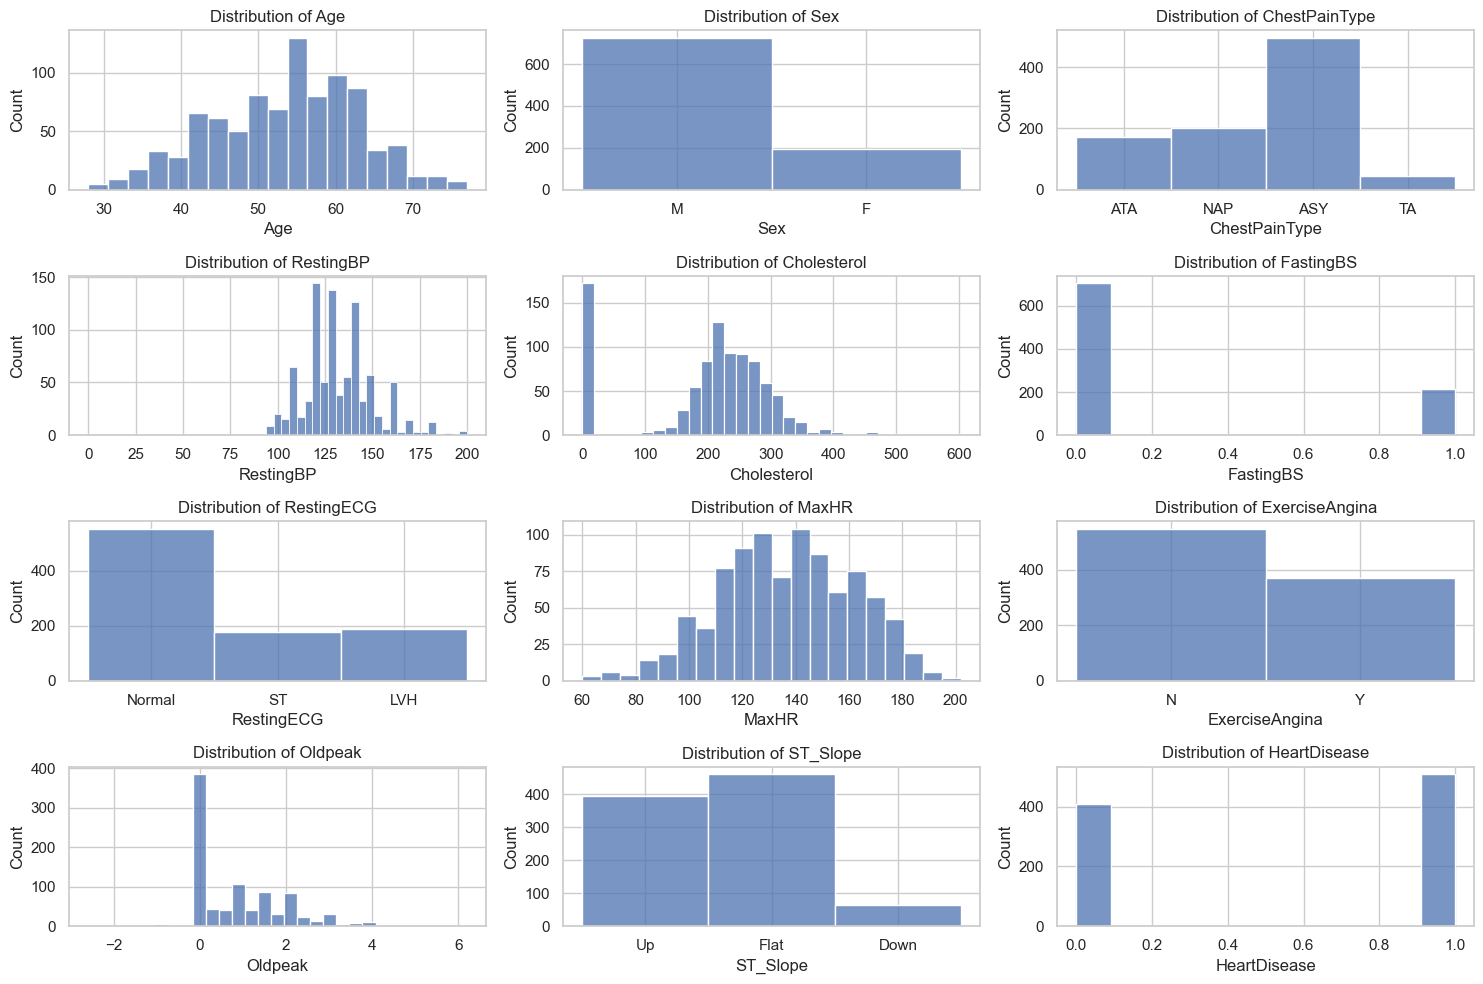

In [11]:
plt.figure(figsize=(15,10))
for i,column in enumerate(data.columns):
    plt.subplot(4,3,i+1)
    plt.title(f"Distribution of {column}")
    sns.histplot(data[column])
    plt.tight_layout()
    plt.plot()

At a first glance, Age, RestingBP, MaxHR seem to be following well a Gaussian distribution. There is definitely inbalance in the Sex variable. Most patients are male. The target variable HeartDisease is quite balanced. Oldpeak is strongly left skewed. For Cholesterol there seem to be many outliers in form of zero values (Cholesterol level should be strictly positive). RestingBP also has a single zero value outlier. For the categorical variables ChestPainType and RestingECG one category is dominating, *ASY* (asymmptomatic) and *Normal* repectively. ExerciseAngina is fairly balanced between *Yes* and *No*. For ST_Slope *Upsloping* and *Flat* are balanced whereas only few patients are diagnosed *Downsloping*. Let's plot the categorical variables against the target variable HeartDisease

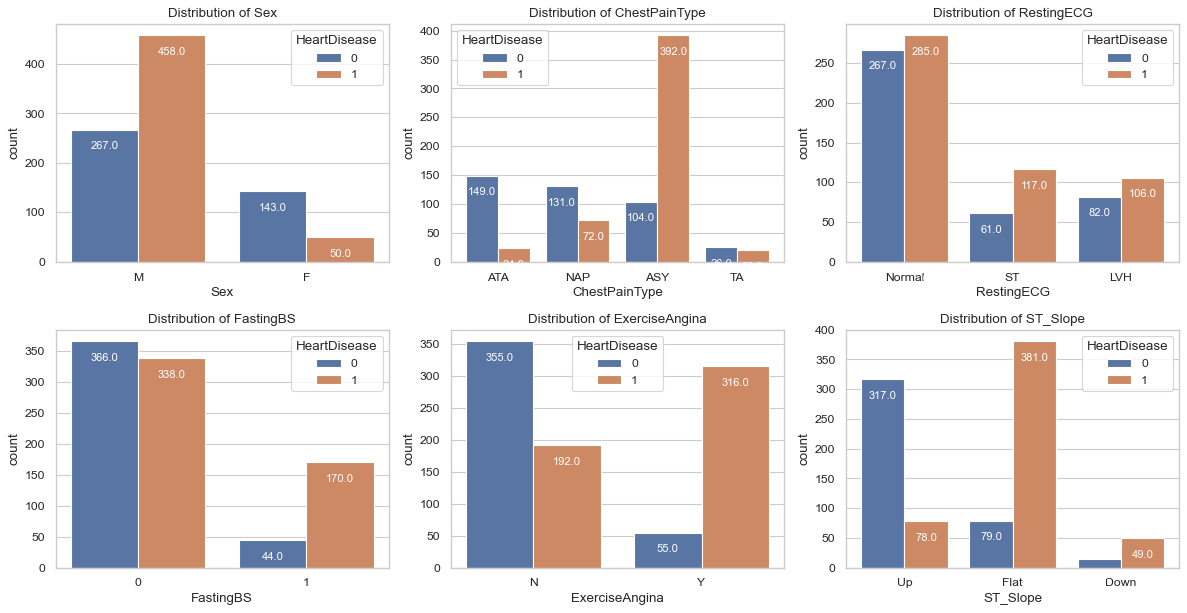

In [12]:
plt.figure(figsize=(15,15), dpi=80)
for i,column in enumerate(data_cat[:6]):
    plt.subplot(4,3,i+1)
    plt.title(f"Distribution of {column}")
    ax = sns.countplot(data=data, x=column, hue="HeartDisease")
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=10)
    plt.tight_layout()
    plt.plot()

Here we gain first insights on which features correlate with Heart Disease. However we have to be careful with interpretations due to the imbalances from the previous plots. 

Those patients that are diagnosed with ChestPainType *ASY* (asymmptomatic) seem to be more likely to have a heart disease than the other categories. Similarily ExcerciseAngina = *Y* and ST_Slope = *Flat* are responsible for most cases with heart disease. For FastingBS we find that for patients with FastingBS <= 120 mg/dl (encoded as 0 meaning no Diabetes) there are equally many cases with and without heart diseases. However for those patiens having FastingBS > 120 mg/dl (encoded as 1 meaning Diabestes) the cases of Heart Diseases clearly dominate.

Interestingly for RestingECG all categories are fairly well balanced meaning that this feature give hardly any insights on the likeliness of a heart disease. 

The distribution of HeartDisease is:
HeartDisease
1    508
0    410
Name: count, dtype: int64

The distribution of Sex is:
Sex
M    725
F    193
Name: count, dtype: int64

Fraction of male having a Heart Disease:  0.63
Fraction of female having a Heart Disease:  0.26


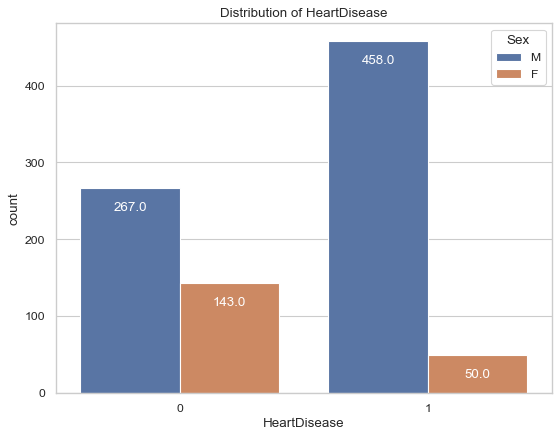

In [13]:
plt.figure(figsize=(8,6),dpi=80)
ax = sns.countplot(data=data, x="HeartDisease", hue="Sex")
ax.set(title='Distribution of HeartDisease')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=12)

print('The distribution of HeartDisease is:')
print(data['HeartDisease'].value_counts())
print()
print('The distribution of Sex is:')
print(data['Sex'].value_counts())
print()
print("Fraction of male having a Heart Disease: ", round(458/725,2))
print("Fraction of female having a Heart Disease: ", round(50/193,2))

Let's focus on Gender and HeartDisease. As mentioned earlier the target variable HeartDisease are fairly equally distributed (410 without heart disease and 508 with heart disease). Gender, on the other hand, is strongly imbalanced (725 mal vs 193 female). Therefore we have to be careful for biases in the dataset. Calculating the fraction of male who have a heart disease (63%) vs. the fraction of female having a heart disease (26%), however, reveals that in fact men are significantly more affected by heart diseases than women at least in this dataset. But as the number of female patients is really low the generalisability of that observation is questionable. Now, let us plot the numerical variables against heart disease.

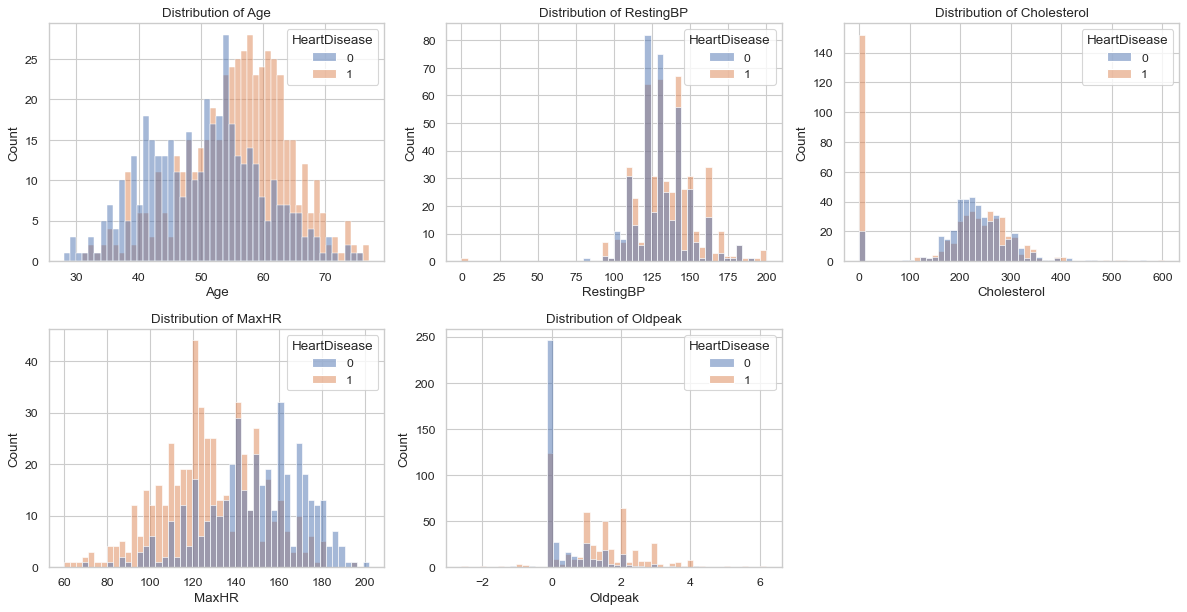

In [14]:
plt.figure(figsize=(15,15), dpi=80)
for i,column in enumerate(data_num):
    plt.subplot(4,3,i+1)
    plt.title(f"Distribution of {column}")
    ax = sns.histplot(data=data, x=column, hue="HeartDisease", bins=50)
    plt.tight_layout()
    plt.plot()

Not surprisingly, the older the patients the more are affected they are by heart diseases. Similary, the lower MaxHR the more patients have a heart disease. Olpeak is less strongly but still positively related to Heart Disease. RestingBP and Cholesterol seem to be fairly invariant to the target variable Heart Disease. There is no clear seperation observable. 

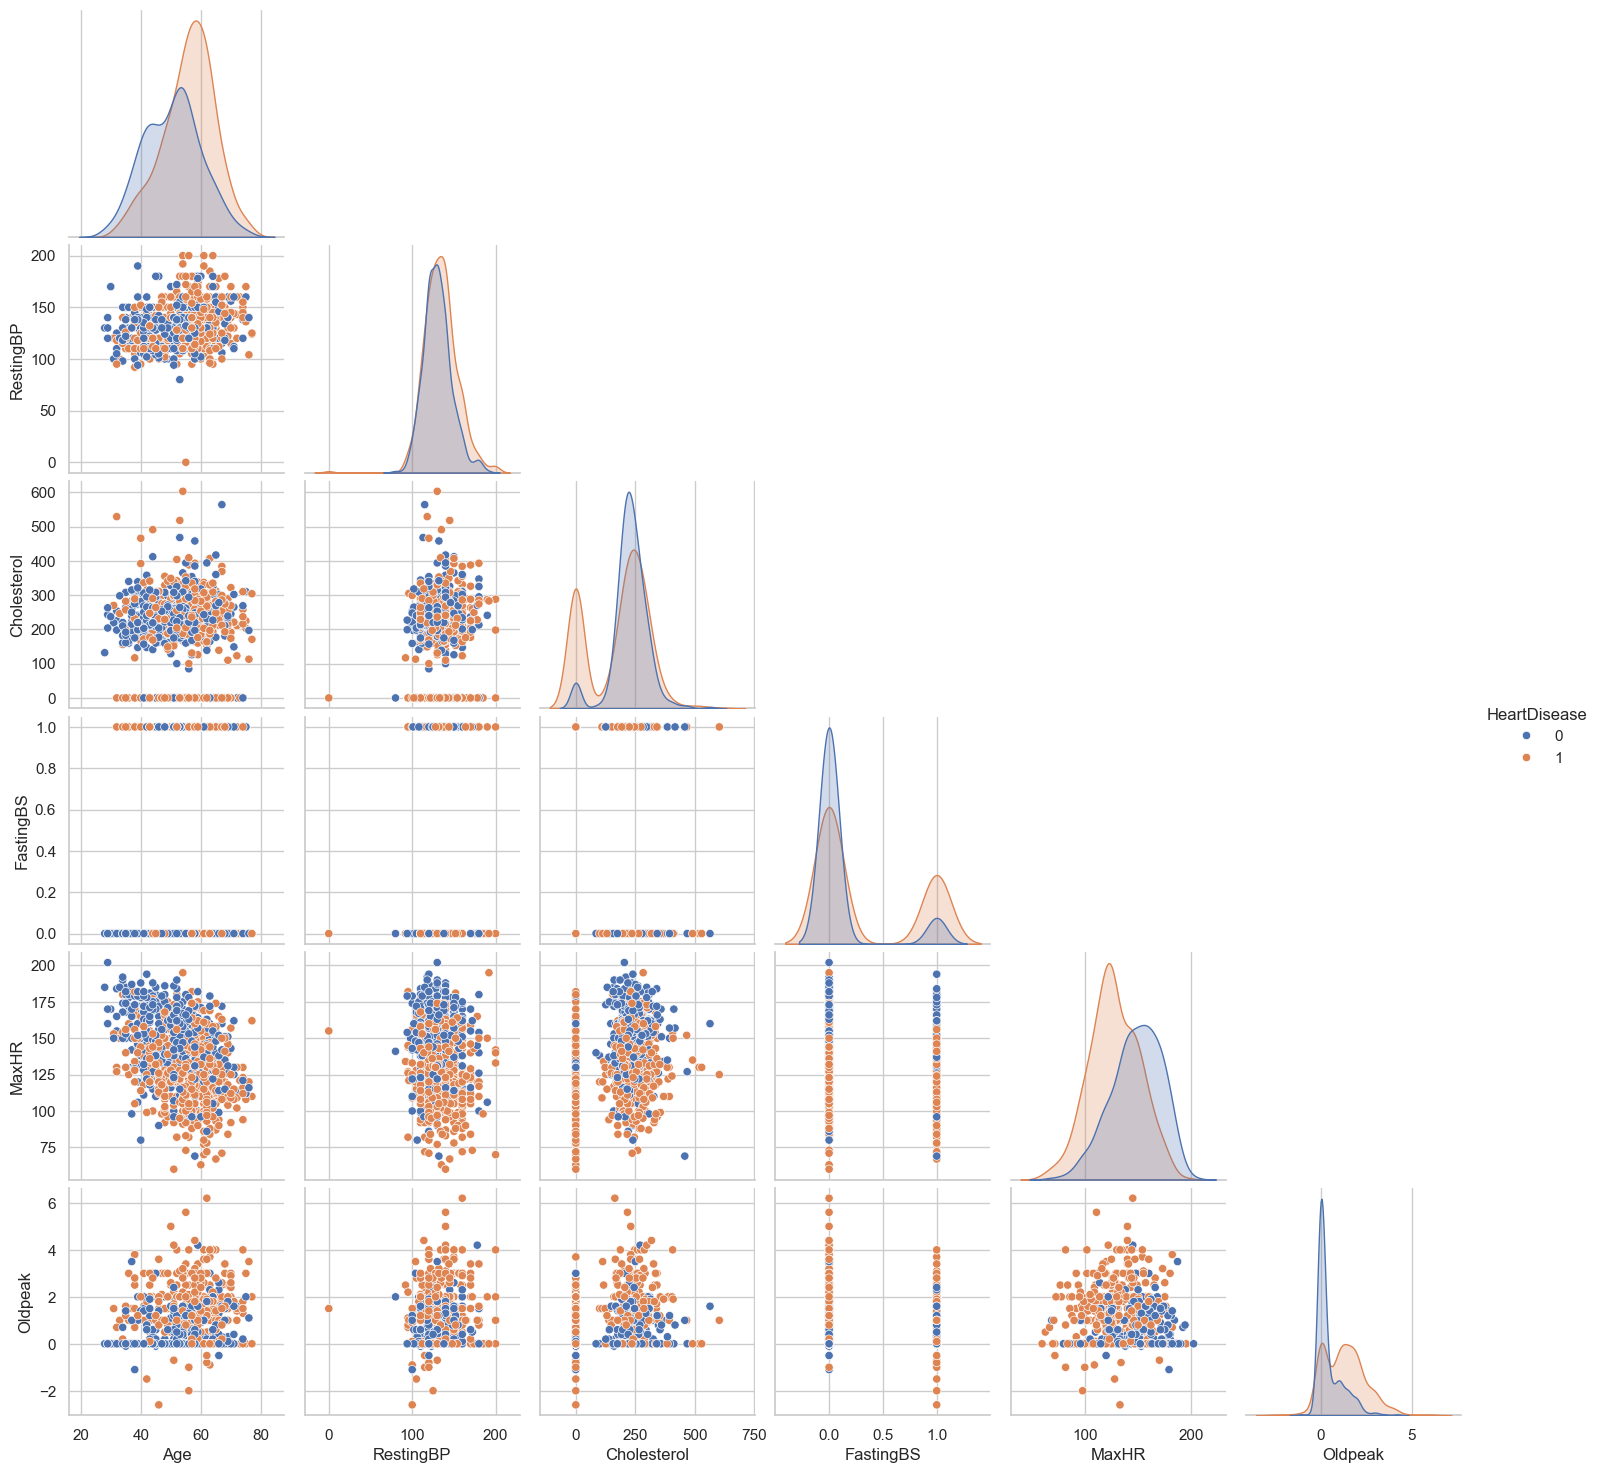

In [15]:
sns.pairplot(data, hue="HeartDisease", corner=True);

Another way to plot the numerical variables are scatter plots. Here we plot the scatter of each pair of numerical variables and differentiate between heart disease (orange) and no heart disease (blue). The key observation is that even though we find similar trends as before there is no way we can split the data using a linear line. That indicates that the relationship between the features and the target variable is quite complex and might follow a non-linear relationship.

Now we address outliers. We use boxplots to identify outliers

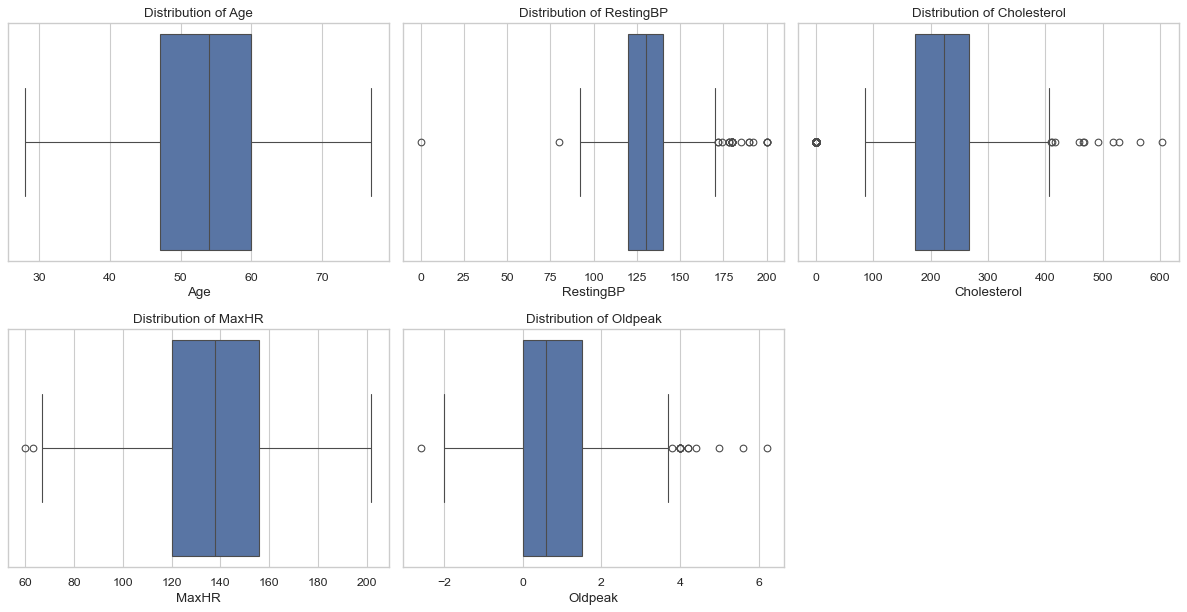

In [16]:
plt.figure(figsize=(15,15), dpi=80)
for i,column in enumerate(data_num):
    plt.subplot(4,3,i+1)
    plt.title(f"Distribution of {column}")
    ax = sns.boxplot(data=data, x=column)
    plt.tight_layout()
    plt.plot()

As we can see there are no outliers for Age. For RestingBP and Cholesterol there are outliers with value 0, which seems like a measurement mistake as Blood Pressue and Cholesterol are strictly positive measures. For Cholesterol most obervations had value 0 as depicted in the Count Plots in the beginning. We will treat those entries as measurement mistake and replace them by the median in the preprocessing section. The other outliers are not as severe and are not seen as measurement mistakes. As the number of datapoints is low already no further outlier handling is done here. 

<a id='3'></a>
## Preprocessing

**Handling outliers**

Firstly, we are replacing the outliers in RestingBP and Cholesterol that were identified as measurement mistakes

In [17]:
meadian_RestingBP = data['RestingBP'].median()
data['RestingBP'].replace(0, meadian_RestingBP,inplace=True)

meadian_Cholesterol = data['Cholesterol'].median()
data['Cholesterol'].replace(0, meadian_Cholesterol,inplace=True)

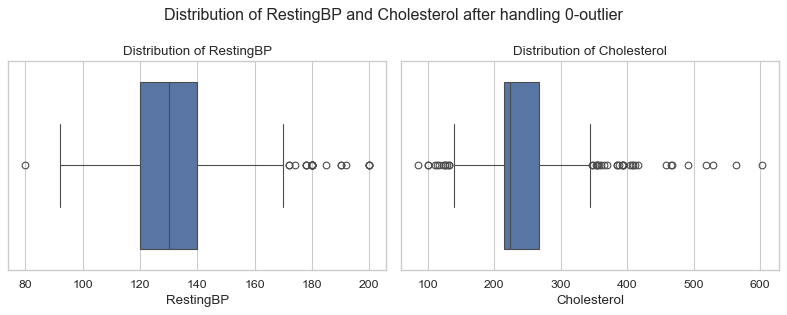

In [18]:
plt.figure(figsize=(10,4), dpi=80)
plt.subplot(1,2,1)
plt.title("Distribution of RestingBP")
sns.boxplot(data=data, x='RestingBP')
plt.subplot(1,2,2)
plt.title(f"Distribution of Cholesterol")
sns.boxplot(data=data, x='Cholesterol')
plt.suptitle("Distribution of RestingBP and Cholesterol after handling 0-outlier")
plt.tight_layout()
plt.show()

No we can see that there are no 0 values anymore and the ranges look more reasonable

**Feature Encoding**

As shown earlier the dataset has no missing values so we don't have to deal with it. However there are 4 categorical variables that we can not input to the Machine Learning Pipeline. Therefore we map categorical variables to integers. Since all categorical variables have a small number of categories (and they can hardly be interpreted as ordinal) we use dummy variables to encode each category into a binary nominal varable. That way we also enable more transparancy when we interpret the models. (one hot encoding)

Data before encoding:

In [19]:
data.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


Data after encoding:

In [20]:
data = pd.get_dummies(data, drop_first=False)
data.head(10)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True
5,39,120,339,0,170,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True
6,45,130,237,0,170,0.0,0,True,False,False,...,False,False,False,True,False,True,False,False,False,True
7,54,110,208,0,142,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
8,37,140,207,0,130,1.5,1,False,True,True,...,False,False,False,True,False,False,True,False,True,False
9,48,120,284,0,120,0.0,0,True,False,False,...,False,False,False,True,False,True,False,False,False,True


**Correlation Matrix**

Note that the number of attributes has increased to 20 as each category represents a single feature. As all attributes are numeric now we can inspect the link between attributes by plotting the correlation matrix which indicates the correlation between each pair of numeric variables.

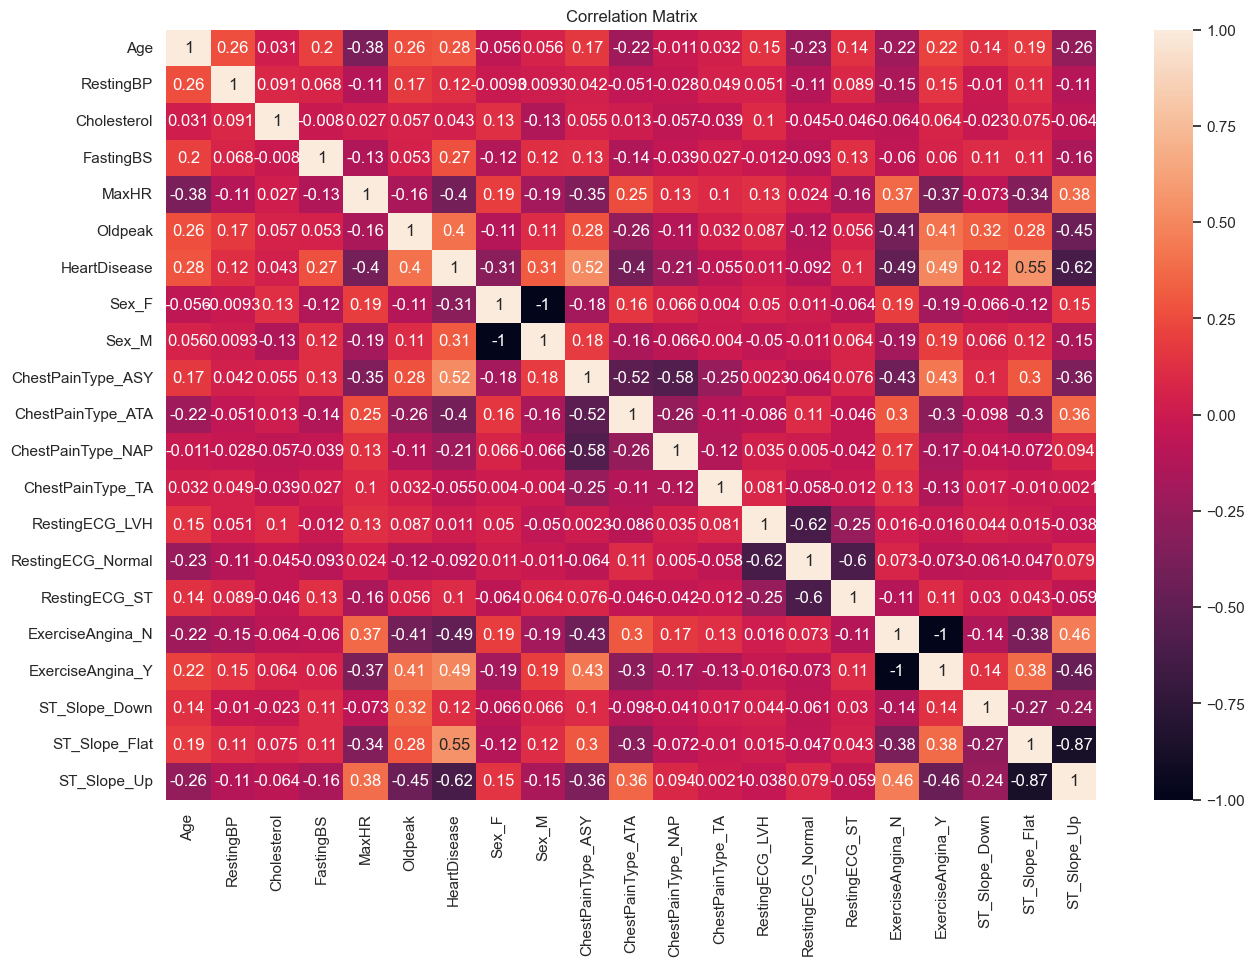

In [21]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),annot = True)
plt.title('Correlation Matrix')
plt.show()

Most importantly we are interested in the the correlation between the target variable HeartDisease and the features. So let's extract the HeartDisease part of the correlation matrix. 

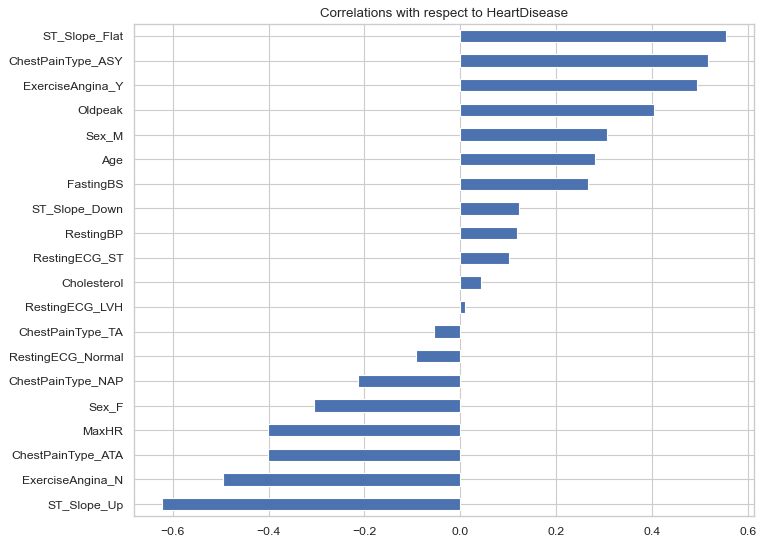

In [22]:
plt.figure(figsize=(10,8),dpi=80)
corr = data.corr()
corr['HeartDisease'].sort_values()[:-1].plot.barh()
plt.title("Correlations with respect to HeartDisease")
plt.show()

We find that HeartDisease is most strongly positively correlated to ST_Slope_Flat (0.55), ChestPainTeype_ASY (0.52) and ExerciseAngina_Y (0.49) while being negatively correlated to ST_Slope_Up (-0.62) and ExerciseAngina_N (-0.49). As mentioned earlier male patients are more effected than female and the older patients are the more Heart Diseases occured. Note that correlations do not mean causal links but we can use correlations to understand which variables play a key role (i.e. ST_Slope, ExerciseAngina, ChestPainType and Oldpeak) and which variables are less important (e.g. RestingBP, RestingECG and Cholesterol).  

**Feature Scaling**

Now we are standardizing the non binary numerical variables which is a best practice in machine learning that ensures that datapoints are not 'too far' from each other while keeping their relation to each other. Algorithms that depend on distance measures such as SVM or KNN are sensitive to the scale of data (graph based models such as decision trees and random forest are invariant to scale). Therefore we have to ensure all feature are on the same scale. Furthermore most linear models (logistic regression, SVM) assume all variables to be normally distributed which will be ensured by standarizing.

In [23]:
for col in data_num:
    data[col] = StandardScaler().fit_transform(data[[col]])
    
data.head(10)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.415002,0.897407,0,1.382928,-0.832432,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,-0.478484,1.527329,-1.122849,0,0.754157,0.105664,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,-1.751359,-0.141161,0.786200,0,-1.525138,-0.832432,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,-0.584556,0.303769,-0.492677,0,-1.132156,0.574711,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,0.051881,0.971166,-0.844832,0,-0.581981,-0.832432,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True
5,-1.539213,-0.697325,1.824130,0,1.304332,-0.832432,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True
6,-0.902775,-0.141161,-0.066385,0,1.304332,-0.832432,0,True,False,False,...,False,False,False,True,False,True,False,False,False,True
7,0.051881,-1.253488,-0.603884,0,0.203982,-0.832432,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
8,-1.751359,0.415002,-0.622419,0,-0.267596,0.574711,1,False,True,True,...,False,False,False,True,False,False,True,False,True,False
9,-0.584556,-0.697325,0.804735,0,-0.660578,-0.832432,0,True,False,False,...,False,False,False,True,False,True,False,False,False,True


Data after Standardization

There are other techniques for scaling such as Normalisation (all features are scaled to a range between 0 and 1) implemented by the MinMaxScaler from sklearn. Also, instead of dummy variables we could also use LabelEncoder which encodes categorical variables into discrete numerical variables where each catecory is mapped to an integer (This is less interpretable but reduces the number of features). Another method is the RobustScaler which is robost with repect to outliers. As we have seen some features seem more important to predict Heart Disease than others. It can be interesting to see how a model performs on a subset of features.  

Let's design a preprocessing pipeline that we can later use in the experimental Analysis to vary these options. 

In [24]:
def preprocess(encoder, scaler, features = ["Sex","ChestPainType","RestingECG","FastingBS","ExerciseAngina",
                                            "ST_Slope","HeartDisease","Age","RestingBP","Cholesterol",
                                            "MaxHR","Oldpeak"]):
    '''
    encoder: 'dummies' for dummy variables or 'LabelEncoder' for integer encoding
    scaler: 'StandardScaler' for Standardization, 'MinMaxScaler' for Normalization, 'RobustScaler' for robust scaling (w.r.t outliers)
    features: list of features to consider, can be used to specify which features to drop.
    '''
    
    # Reading fresh data 
    data = pd.read_csv("heart.csv",header=0)
    
    # Drop features that are not included in the features list    
    all_features = list(data.columns)
    dropped_features = [feature for feature in all_features if feature not in features]
    data.drop(dropped_features, axis=1, inplace=True)  
    
    # Identify numerical and categorical attributes
    data_cat = ["Sex","ChestPainType","RestingECG","FastingBS","ExerciseAngina","ST_Slope","HeartDisease"]
    data_num = ["Age","RestingBP","Cholesterol","MaxHR","Oldpeak"]
    
    data_cat = [feature for feature in data_cat if feature in features]
    data_num = [feature for feature in data_num if feature in features]
    
    # Removing outliers
    if 'RestingBP' in features:
        meadian_RestingBP = data['RestingBP'].median()
        data['RestingBP'].replace(0, meadian_RestingBP,inplace=True)

    if 'Cholesterol' in features:
        meadian_Cholesterol = data['Cholesterol'].median()
        data['Cholesterol'].replace(0, meadian_Cholesterol,inplace=True)

    # Encode categorical variables
    if encoder == "dummies":
        data = pd.get_dummies(data, drop_first=False)
    elif encoder == "LabelEncoder":
        data = data.apply(LabelEncoder().fit_transform)
    else:
        print('encoder must be "dummies" or "LabelEncoder"')
        return
    
    # Data Scaling
    for col in data_num:
        if scaler == 'StandardScaler':
            data[col] = StandardScaler().fit_transform(data[[col]])
        elif scaler == 'MinMaxScaler':            
            data[col] = MinMaxScaler().fit_transform(data[[col]])
        elif scaler == 'RobustScaler':            
            data[col] = RobustScaler().fit_transform(data[[col]])
        else:
            print('scaler must be "StandardScaler" or "MinMaxScaler" or "RobustScaler"')
            return
        
    return data

<a id='4'></a>
## 4 Task and evaluation


**Task**

The goal is to correctly classify as many patients as possible on the target variable HeartDisease as possible given the features. Since every obseravation is labled with the corresponding target the task is a standard classification problem. We will apply a standard Machine Learning apprach meaning no Deep Learning. The reason is that 918 are normally not enough to train a neural network effectively. We have seen in Exploratory Data Analysis (EDA) part that some feature are more insightful than others. So we will experiment on which features can be dropped in the Experimental Analysis part.  

Predicting health related issues like Heart Diseases comes with high responsibility. Choosing the right metric is crucial. 

**Metric**

Diagnosing no heart disease while a patient actually has a heart disease (false negative) is the worst possible outcome and therefore associated with high cost. From [towardsdatascience] we know that: 

"Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative".

So recall will be the main metric of interesst in this study. Percision is a the main metric when false positives are associated with high costs. However false negatives (patient is classified to have heart disease while there is actually no heart disease) are obviously less expensive than false negatives (expensive in terms of impact on a patient's health). We still take accuracy into account because recall = 1 can be easily achieved by classifiying all patients as having a Heart Disease but accuracy also takes into account how many negatives were correctly classified. The goal is therefore to reach high recall while accuracy is good too. 

<a id='5'></a>
## 5 Design and build an ML system


We will follow the same approach as in [Alotaibi] and try out a range of different standard Machine Learning models (Logistic Regression, Gaussian Naive Bayes, Support Vector Machines, K Nearest Neighbors, Decision Trees and Random Forest) and make some observation on their default configuration. We will then design a flexible pipeline (run() function) that allows to take any sklearn API based classifier to make comparisions and pick the model that performs best. Later we will also discuss the suitablity of a classifier in terms of interpretability.

Lets first extract the target variable split the data into a train and a test set (we choose a 80/20 split after some manual experimentation)

In [25]:
# Features
X = data[data.columns.drop(['HeartDisease'])].values
# Target
y =  data['HeartDisease'].values

# Test Train Split (20% test set size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)

some functions to automate the whole process

In [26]:
def setup(data, test_size):
    # Features
    X = data[data.columns.drop(['HeartDisease'])].values
    # Target
    y =  data['HeartDisease'].values
    # Test Train Split (20% test set size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 10)
    return X_train, X_test, y_train, y_test

def fit(classifier, X_train, y_train):
    # Fitting the model
    classifier.fit(X_train,y_train)
    return classifier

def predict(classifier_fitted, X):
    # Predict on test data
    y_pred = classifier_fitted.predict(X)
    return y_pred

def cm(y_test, y_pred):
    # plotting the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Heart Disease', 'Heart Disease'])
    cm_display.plot()
    plt.show()
    
def calssification_report(y_test, y_pred):
    # printing the classification report
    testreport = classification_report(y_test, y_pred)
    print(testreport)


############################## LogisticRegression() ##############################


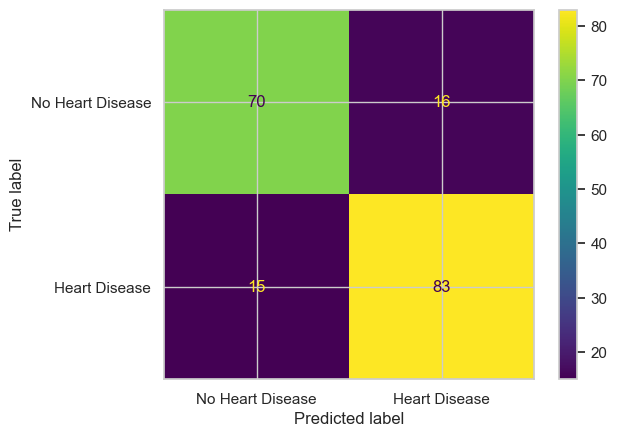

              precision    recall  f1-score   support

           0       0.82      0.81      0.82        86
           1       0.84      0.85      0.84        98

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184

Recall:  0.85
Train Accuracy:  0.88
Test Accuracy:  0.83 

############################## GaussianNB() ##############################


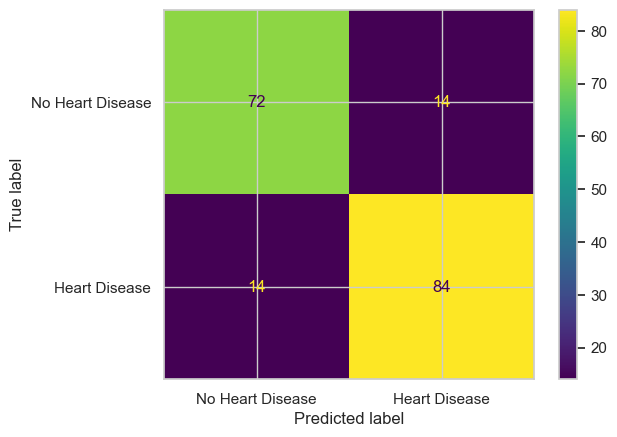

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        86
           1       0.86      0.86      0.86        98

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

Recall:  0.86
Train Accuracy:  0.86
Test Accuracy:  0.85 

############################## SVC() ##############################


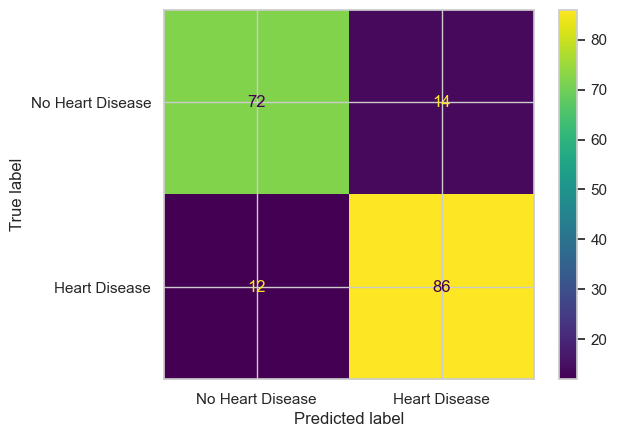

              precision    recall  f1-score   support

           0       0.86      0.84      0.85        86
           1       0.86      0.88      0.87        98

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Recall:  0.88
Train Accuracy:  0.91
Test Accuracy:  0.86 

############################## KNeighborsClassifier() ##############################


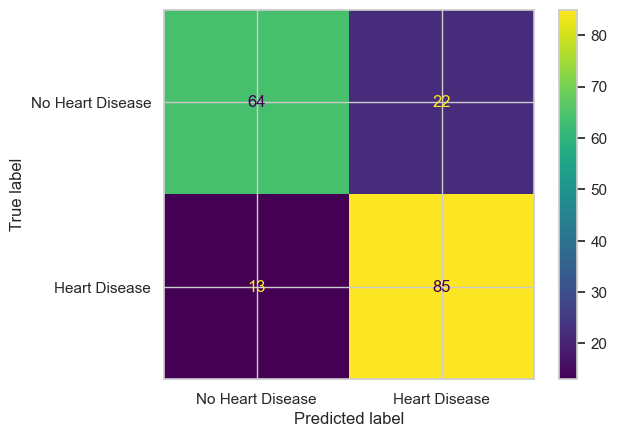

              precision    recall  f1-score   support

           0       0.83      0.74      0.79        86
           1       0.79      0.87      0.83        98

    accuracy                           0.81       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.81      0.81      0.81       184

Recall:  0.87
Train Accuracy:  0.9
Test Accuracy:  0.81 

############################## DecisionTreeClassifier() ##############################


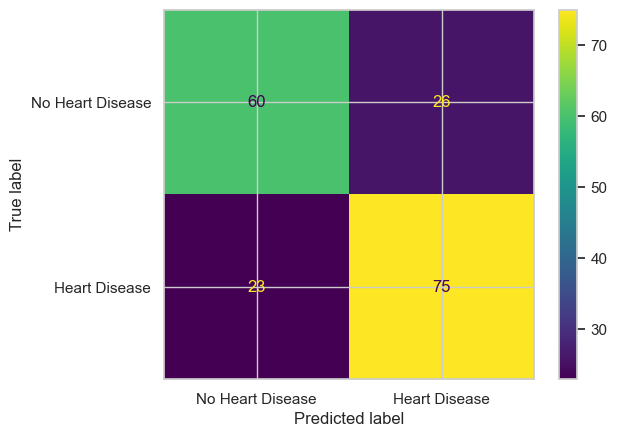

              precision    recall  f1-score   support

           0       0.72      0.70      0.71        86
           1       0.74      0.77      0.75        98

    accuracy                           0.73       184
   macro avg       0.73      0.73      0.73       184
weighted avg       0.73      0.73      0.73       184

Recall:  0.77
Train Accuracy:  1.0
Test Accuracy:  0.73 

############################## RandomForestClassifier() ##############################


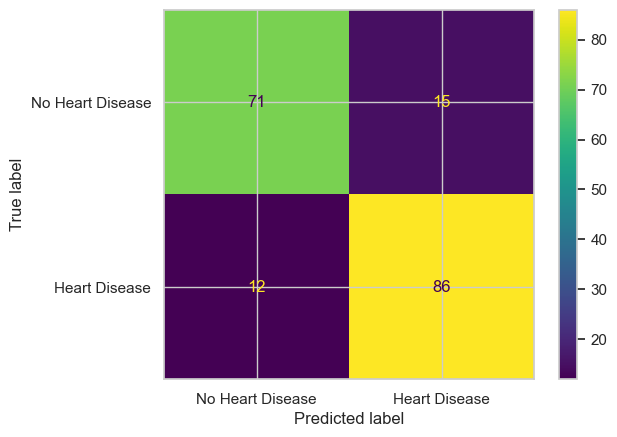

              precision    recall  f1-score   support

           0       0.86      0.83      0.84        86
           1       0.85      0.88      0.86        98

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

Recall:  0.88
Train Accuracy:  1.0
Test Accuracy:  0.85 



In [27]:
# The classifers that we will use, can be extended
classifiers = [LogisticRegression(),
          GaussianNB(), 
          SVC(), 
          KNeighborsClassifier(), 
          DecisionTreeClassifier(), 
          RandomForestClassifier(),
         ]

# Names for printing the table
classifier_names = ["LR", "NB", "SVM", "KNN", "DT", "RF"]

recall_list = []
accuracy_train_list = []
accuracy_test_list = []


for classifier in classifiers:
    
    # Fitting
    classifier_fitted = fit(classifier, X_train, y_train)
    # Predicting
    y_pred_train = predict(classifier_fitted, X_train)
    y_pred_test = predict(classifier_fitted, X_test)
    # Recall
    recall_clf = recall_score(y_test, y_pred_test).round(2)
    # Accuracy
    acc_clf_train = accuracy_score(y_train, y_pred_train).round(2)
    acc_clf_test = accuracy_score(y_test, y_pred_test).round(2)
    
    print('#'*30, f'{classifier}', '#'*30)
    # Confusion Matrix
    cm(y_test, y_pred_test)
    # Classification Report
    calssification_report(y_test, y_pred_test)
    print(f"Recall: ", recall_clf)
    print(f"Train Accuracy: ", acc_clf_train)
    print(f"Test Accuracy: ", acc_clf_test, '\n')

    recall_list.append(recall_clf)
    accuracy_train_list.append(acc_clf_train)    
    accuracy_test_list.append(acc_clf_test)
    

In [29]:
def recall_table(recall_list, accuracy_test_list, accuracy_train_list, classifier_names):
    recall_df = pd.DataFrame({"Classifier": classifier_names, 
                              "Recall": recall_list, 
                              "Test Accuracy": accuracy_test_list, 
                              "Train Accuracy": accuracy_train_list})
    print(recall_df.to_string(index=False))

recall_table(recall_list, accuracy_test_list, accuracy_train_list, classifier_names)

Classifier  Recall  Test Accuracy  Train Accuracy
        LR    0.85           0.83            0.88
        NB    0.86           0.85            0.86
       SVM    0.88           0.86            0.91
       KNN    0.87           0.81            0.90
        DT    0.77           0.73            1.00
        RF    0.88           0.85            1.00


As we can see Decision Trees and Random Forest are overfitting (Train Accuracy = 1). The relationship between the features and the target variable Heart Disease might be too complex (as depicted during EDA) to capture it using a graph based model. Therefore we will no longer consider the tree models. Most promising is the SVM model with recall = 0.88 and test accuracy = 0.86 while train acc = 0.91. 

Let's write a more flexible pipeline function that can take any set of classifiers. It will train predict and evalute the models in one function. We also include the option to apply dimensionality reduction using PCA (with a specific number of components) before the data is fitted. We will make use of that in the next section. 

In [30]:
def run(classifiers, data, test_size, report=False, confusion_matrix=False, pca=False,  n_components=5):
    """
    Generalize the same experiment with any set of classifier and data. Data should have a 'HeartDisease' column

        Input:
        classifiers: set of ML classifiers
        data: pandas dataframe of the data
        test_size: float between 0 and 1 to define the train test split
        
        Return:
        recall_table: pandas dataframe with recall for each classifier
        
    """
    # Test Train Split (20% test set size)
    X_train, X_test, y_train, y_test = setup(data, test_size)
    
    # Apply PCA:
    if pca:
        pca_model = PCA(n_components=n_components)
        X_train = pca_model.fit_transform(X_train)
        X_test = pca_model.transform(X_test)
        # print("Variance explained by {n_components} Components: ", pca_model.explained_variance_)
    
    recall_list = []
    accuracy_train_list = []
    accuracy_test_list = []
    
    for classifier in classifiers:
        
        #Fitting
        classifier_fitted = fit(classifier, X_train, y_train)
        
        #Predicting
        y_pred_train = predict(classifier_fitted, X_train)
        y_pred_test = predict(classifier_fitted, X_test)
        
        #Recall
        recall_clf = recall_score(y_test, y_pred_test).round(2)
        
        #Accuracy
        acc_clf_train = accuracy_score(y_train, y_pred_train).round(2)
        acc_clf_test = accuracy_score(y_test, y_pred_test).round(2)
        
        
        if report or confusion_matrix:
            print('#'*30, f'{classifier}', '#'*30)
        if report:
            calssification_report(y_test, y_pred_test)
        if confusion_matrix: 
            cm(y_test, y_pred_test)

        recall_list.append(recall_clf)
        accuracy_train_list.append(acc_clf_train)    
        accuracy_test_list.append(acc_clf_test)

    return recall_list, accuracy_test_list, accuracy_train_list
    

<a id='6'></a>
## 6 Experimental analysis (performance & scalability)

**Varying Encoding and Scaling**

First we will test how the same set of classifers will perform using the different methods for encoding categorical variables (dummies vs. LabelEncoder) and for feature scaling (standardisation vs. normalisation vs. robust scaling). 

In [31]:
encoders = ['dummies', 'LabelEncoder']
scalers = ['StandardScaler', 'MinMaxScaler', 'RobustScaler']
classifiers = [LogisticRegression(),
          GaussianNB(), 
          SVC(), 
          KNeighborsClassifier(), 
         ]
classifier_names = ["LR", "NB", "SVM", "KNN"]

test_size = 0.2 # after testing some other splits 80/20 train test split performed best 

for encoder in encoders:
    for scaler in scalers:
        data = preprocess(encoder, scaler)        
        recall_list, accuracy_test_list, accuracy_train_list = run(classifiers, data, test_size)
        print(f"Encoder: {encoder}, ", f"Scaler: {scaler}, ", "\n")
        recall_table(recall_list, accuracy_test_list, accuracy_train_list, classifier_names)
        print("Sum recall: ", sum(recall_list).round(2), "Sum Test Accuracy: ", sum(accuracy_test_list).round(2))
        print("-"*60)

Encoder: dummies,  Scaler: StandardScaler,  

Classifier  Recall  Test Accuracy  Train Accuracy
        LR    0.85           0.83            0.88
        NB    0.86           0.85            0.86
       SVM    0.88           0.86            0.91
       KNN    0.87           0.81            0.90
Sum recall:  3.46 Sum Test Accuracy:  3.35
------------------------------------------------------------
Encoder: dummies,  Scaler: MinMaxScaler,  

Classifier  Recall  Test Accuracy  Train Accuracy
        LR    0.85           0.83            0.87
        NB    0.86           0.85            0.86
       SVM    0.90           0.84            0.89
       KNN    0.89           0.82            0.89
Sum recall:  3.5 Sum Test Accuracy:  3.34
------------------------------------------------------------
Encoder: dummies,  Scaler: RobustScaler,  

Classifier  Recall  Test Accuracy  Train Accuracy
        LR    0.85           0.83            0.87
        NB    0.86           0.85            0.86
       SV

As expected the scaling technique has no effect on either Naive Bayes or Logistic Regression as they do not use distances measure in their decision boundary. For SVM and KNN however we find slightly better recall using normalization (MinMaxScaler) instead of standardisation (StandardScaler). As for dummies vs. label encoding there are almost no difference. As dummies variables are more interpretable than label encoding we will go on with dummy variables and normalisation.   

With that the best performing model we have is SVM with recall = 0.9 and test accuracy = 0.84. Now we will try to further improve SVMs performance using hyperparameter tuning. 

The data we are using from now on uses dummy variables and MinMaxScaler:

In [32]:
data = preprocess("dummies", "MinMaxScaler")   

test_size = 0.2

# Test Train Split (20% test set size)
X_train, X_test, y_train, y_test = setup(data, test_size)

Let's perform GridSearch on SVC (optimizing on recall)

In [33]:
# SCV:
parameters = {
    "C": [0.001, 0.01,0.5,1,2],
    "gamma": [0.001, 0.01, 0.05, 0.1,1],
    "kernel": ['linear', 'rbf', 'sigmoid'],
}

# Create an instance of the SVC class
clf = SVC()

# Create an instance of the GridSearchCV class
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=parameters,
    cv=5,  # Use 5-fold cross-validation
    scoring='recall'  # Use recall as the scoring metric
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameter for SVC optimized on recall: ", grid_search.best_params_)

Best parameter for SVC optimized on recall:  {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}


############################## SVC(C=0.001, gamma=0.001, kernel='linear') ##############################
              precision    recall  f1-score   support

           0       1.00      0.12      0.21        86
           1       0.56      1.00      0.72        98

    accuracy                           0.59       184
   macro avg       0.78      0.56      0.46       184
weighted avg       0.77      0.59      0.48       184



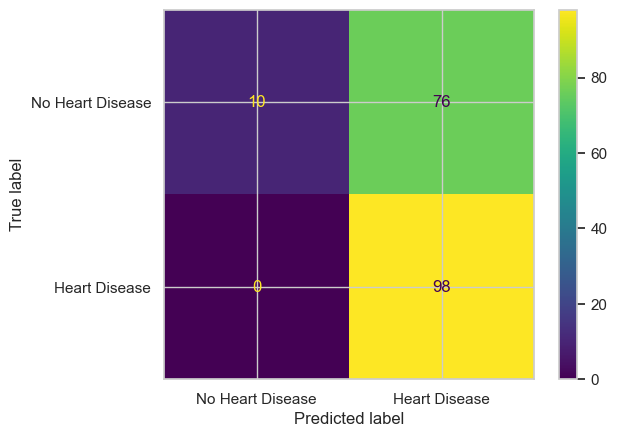

    Classifier  Recall  Test Accuracy  Train Accuracy
SVC_SearchGrid     1.0           0.59            0.63


In [35]:
classifiers = [
                SVC(C=0.001 ,gamma=0.001, kernel='linear'),
            ]

classifier_names = ["SVC_SearchGrid"]

recall_list, accuracy_test_list, accuracy_train_list = run(classifiers, data, 0.2, confusion_matrix=True, report=True)
recall_table(recall_list, accuracy_test_list, accuracy_train_list, classifier_names)

Here we find that when optimizing gridSearch for recall, SVM predicts zero false negatives (recall = 1.0). However, accuracy is very low (0.59). 76 out of 86 patients were falsly classified with a heart disease. Therefore, the model is poor overall. Remember any model can get recall = 1 by just classifying every observation as positive. 

After some experimentation, I figured that GridSearch optimized for accuracy will suffer under reduced recall. Therefore I manually tuned the parameters since this specific application requires high recall while having good accuracy. I found that SVM with regularization C=0.01, polynomial kernel with degree 3 and gamma=1.3 to perform best. Leveraging SVM potential to capture non linear relations using a polynomial kernel is motivited by the fact that from EDA the data seem not to be linearly seperable in the input feature space. SVM makes use of the kernel trick to find a hyperplane in a higher dimensional feature space to seperate the two classes. Additionally, for overlapping data (seen in EDA) SVM makes use of the soft margin approach which allows some misclassification on the training data to generalize better on test data. SVM is also known to perform well on small to medium size datasets which is clearly the case (918 observations)

############################## SVC(C=0.01, gamma=1.3, kernel='poly') ##############################
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        86
           1       0.83      0.91      0.87        98

    accuracy                           0.85       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184



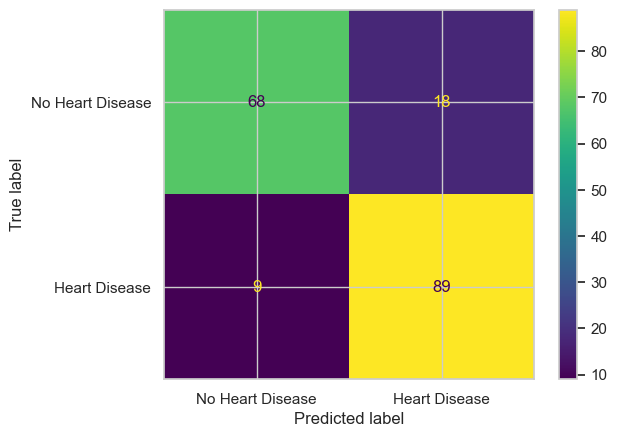

        Classifier  Recall  Test Accuracy  Train Accuracy
SVC_manually_tuned    0.91           0.85            0.89


In [36]:
classifiers = [
                SVC(C=0.01, gamma=1.3, kernel='poly', degree=3) # 0.91 recall, 0.85 acc 
            ]

classifier_names = ["SVC_manually_tuned"]

recall_list, accuracy_test_list, accuracy_train_list = run(classifiers, data, 0.2, confusion_matrix=True, report=True)
recall_table(recall_list, accuracy_test_list, accuracy_train_list, classifier_names)

This model has high recall (0.91) while having good overall accuracy (0.85) which is a further improvement from the default SVM using a linear kernel.

Let's make these estimates more robust and make sure we are not overfitting by performing a 20-fold cross validation. 

In [38]:
classifier = SVC(C=0.01, gamma=1.3, kernel='poly', degree=3)

# Features
X = data[data.columns.drop(['HeartDisease'])].values
# Target
y =  data['HeartDisease'].values

scores_acc = cross_val_score(classifier, X, y, cv=20, scoring='accuracy')
scores_recall = cross_val_score(classifier, X, y, cv=20, scoring='recall')

def cv_table(scores_acc, scores_recall):
    fold = np.arange(1,len(scores_acc)+1)
    recall_df = pd.DataFrame({"Fold": fold, "Score Accuracy": scores_acc, "Score Recall": scores_recall})
    print(recall_df.to_string(index=False))

cv_table(scores_acc, scores_recall)

print()
print(f"Mean cross-validation score for accuracy: {scores_acc.mean():.3f}")
print(f"Mean cross-validation score for recall: {scores_recall.mean():.3f}")
print()
print(f"Standard deviation cross-validation score for accuracy: {scores_acc.std():.3f}")
print(f"Standard deviation cross-validation score for recall: {scores_recall.std():.3f}")


 Fold  Score Accuracy  Score Recall
    1        0.934783      0.960000
    2        0.869565      0.920000
    3        0.913043      0.920000
    4        0.956522      1.000000
    5        0.934783      0.920000
    6        0.847826      0.840000
    7        0.934783      0.920000
    8        0.891304      0.880000
    9        0.956522      1.000000
   10        0.739130      0.880000
   11        0.826087      1.000000
   12        0.804348      0.961538
   13        0.782609      0.923077
   14        0.934783      1.000000
   15        0.869565      0.923077
   16        0.804348      0.730769
   17        0.782609      0.769231
   18        0.804348      0.807692
   19        0.755556      0.680000
   20        0.755556      0.680000

Mean cross-validation score for accuracy: 0.855
Mean cross-validation score for recall: 0.886

Standard deviation cross-validation score for accuracy: 0.072
Standard deviation cross-validation score for recall: 0.100


As we can see the results are fairly robust (standard deviation <= 0.1). We obtain a mean for accuracy of 0.855 and 0.886 for recall.  

Now we can try to reduce the number of features to make the model computationally less expensive, more scalable and more transparent. From the EDA section we know that RestingBP, Cholesterol and are probably not contibuting much to predicting HeartDisease. Therefore might be able to leave out those features. 

In [39]:
features = ["Sex",
            "ChestPainType",
            "RestingECG",
            "FastingBS",
            "ExerciseAngina",
            "ST_Slope",
            "HeartDisease",
            "Age",
            #"RestingBP", # same results
            #"Cholesterol", # same results
            #"MaxHR", # same results
            "Oldpeak"
           ]

data = preprocess("dummies", "MinMaxScaler", features= features)   

classifiers = [
                SVC(C=0.01, gamma=1.3, kernel='poly', degree=3) # 0.91 recall, 0.85 acc
                ]

classifier_names = ["SVC w/o ['RestingBP', 'Cholesterol', 'MaxHR']"]

recall_list, accuracy_test_list, accuracy_train_list = run(classifiers, data, 0.2, confusion_matrix=False, report=False)
recall_table(recall_list, accuracy_test_list, accuracy_train_list, classifier_names)

                                   Classifier  Recall  Test Accuracy  Train Accuracy
SVC w/o ['RestingBP', 'Cholesterol', 'MaxHR']    0.91           0.85            0.89


And indeed, as we can see for SVC without ['RestingBP', 'Cholesterol'] recall and accuracy stay as good as with all features. Interestingly, the performance remained unchanged when additionally MaxHR was removed even though it was found the be negatively correlated with HeartDisease in the EDA section. Conversely, when RestingECG (uncorrelated to HeartDisease) was removed the performance unexpectedly decreased. These effects are most probably related with the fact that the features themselves are also correlated to each other. 

In [40]:
data.shape

(918, 18)

We have reduced the number of feature to 17 (without HeartDisease). We can try to further reduce the number of features by applying Principal Component Analysis. 

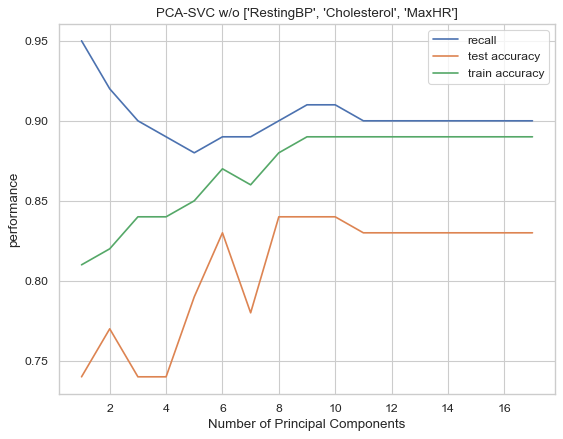

9 Principal Components:
                                       Classifier  Recall  Test Accuracy  Train Accuracy
PCA-SVC w/o ['RestingBP', 'Cholesterol', 'MaxHR']    0.91           0.84            0.89


In [42]:
classifier_names = ["PCA-SVC w/o ['RestingBP', 'Cholesterol', 'MaxHR']"]

n_components = np.arange(1,18)
recall_list, accuracy_test_list, accuracy_train_list = [], [], []

for n_component in n_components:
    recall, accuracy_test, accuracy_train = run(classifiers, data, 0.2, confusion_matrix=False, report=False, 
                                 pca=True, n_components=n_component)
    recall_list.append(recall)
    accuracy_test_list.append(accuracy_test)
    accuracy_train_list.append(accuracy_train)
    
plt.figure(figsize=(8,6),dpi=80)
plt.plot(n_components, recall_list, label="recall")
plt.plot(n_components, accuracy_test_list, label="test accuracy")
plt.plot(n_components, accuracy_train_list, label="train accuracy")
plt.xlabel("Number of Principal Components")
plt.ylabel("performance")
plt.title("PCA-SVC w/o ['RestingBP', 'Cholesterol', 'MaxHR']")
plt.legend()
plt.show()

print("9 Principal Components:")
recall_table(recall_list[9], accuracy_test_list[9], accuracy_train_list[9], classifier_names)

As the graph is showing we can't improve the model using PCA, however using 9 principal components yield same recall (0.91) and almost same accuracy (0.84 vs 0.85 before). So this way we are reducing the dimension from 17 to 9 which makes the model more computationally efficient and scalable (but less interpretable).

Some more general thoughts: 

1) **What have we done?**: After varing different Encoding and Scaling techniques we found that KNN and SVM performed best using dummy encoding and normalisation scaling. We leveraged SVM's performace by applying a polynomial kernel with degree 3. That was motivated be the fact that we have a small dataset with overlapping data. Finally we reduced the number of features while keeping the same performace both manually and using PCA. 

2) **How does the model perform compared to others?**: From the section on previous work we find that our model achieves not as high accuracy as in [Alotaibi]. However, [Alotaibi] was working on a small subset of this data. The results from the kaggle notbook [tanmay111999] are comparable (SVM: 0.875 vs. 0.85). We are putting more focus on recall as we want to minimize false negatives. 

4) **How can we further improve the performance and is the performance enough for the application that we are addressing?**: We need more data. 918 observations is a very small dataset for a machine learning model. Even though we obtain quite good performance using SVM (as SVM is not as 'data-hungry' than other models) we would need much more data to obtain more robust results. The application is health realted so before deploying such a model, reliablity and performance have to really good. A possible approach to mitigate that problem are data augmentation techniques such as using GANs to generate new samples, adding noise to the data or translating the data in different directions to increase the number of datapoints. I leave that to future work.

<a id='7'></a>
## 7 Ethical considerations

**Interpretability**

One of biggest issues with Machine Learning approaches is the lack of interpretablity. Especially in a health related domain like this one predictions of the model come with immense risk and responsibilty. Therefore we aim to improve interpratability by indicating feature importance. That way doctors have insights into how the model comes to a decision. Doctors can then use their domain knowledge to enhance the model's decision.

For SVM, we can use the coefficients of the fitted model to explain the influence of each feature on the decision boundary. However for SVM this interpretation of feature importance only holds for SVM with linear kernel. The model we have build so far (SVM with polynomial kernel of degree 3) operates in a higher dimensional feature space where the coefficients do not directly translate into feature importance. So this is clearly a disadvantage of our model. Let us consider SVM with a linear kernel.

After some experimentation with linear SVM the following model performed best in terms of recall and accuracy.

In [43]:
features = ["Sex",
            "ChestPainType",
            "RestingECG",
            "FastingBS",
            "ExerciseAngina",
            "ST_Slope",
            "HeartDisease",
            "Age",
            "RestingBP",
            "Cholesterol",
            "MaxHR", 
            "Oldpeak"
           ]

data = preprocess("dummies", "MinMaxScaler", features=features)   
X_train, X_test, y_train, y_test = setup(data, test_size = 0.2)
classifier = [SVC(C=0.01, kernel='linear')]

classifier_names = ["linear SVC (C=0.01)]"]

recall_list, accuracy_test_list, accuracy_train_list = run(classifier, data, 0.2, confusion_matrix=False, report=False)
recall_table(recall_list, accuracy_test_list, accuracy_train_list, classifier_names)


          Classifier  Recall  Test Accuracy  Train Accuracy
linear SVC (C=0.01)]    0.88           0.86            0.86


**Feature Imprtance**:

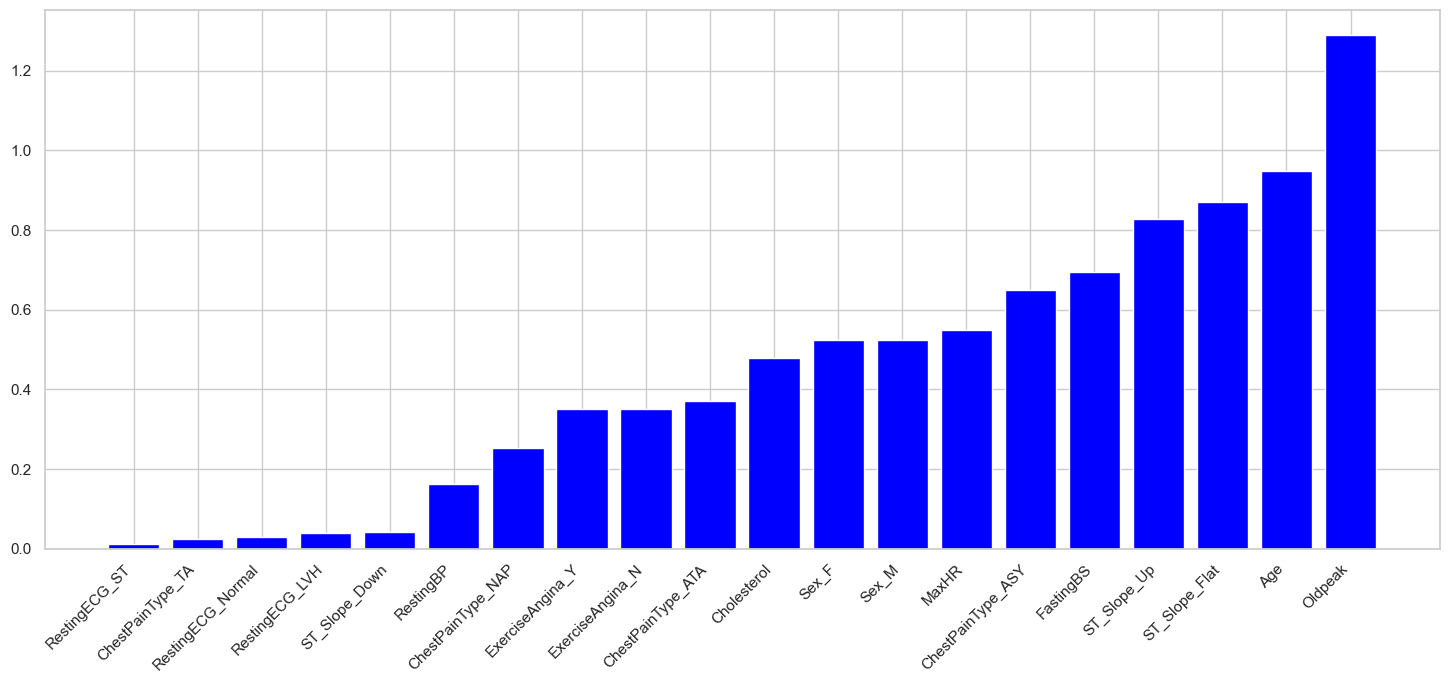

In [44]:
X_train, X_test, y_train, y_test = setup(data, test_size = 0.2)

# taken from https://www.kaggle.com/code/pierpaolo28/pima-indians-diabetes-database/notebook
def feature_plot(classifier, feature_names, top_features=15):
    n_features = len(feature_names)
    coef = abs(classifier.coef_.ravel())
    top_coefficients = np.argsort(coef)
    plt.figure(figsize=(18, 7))
    plt.bar(np.arange(n_features), coef[top_coefficients], color='blue')
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(n_features), feature_names[top_coefficients], rotation=45, ha='right')
    plt.show()

classifier = SVC(C=1, kernel='linear') 
fit(classifier, X_train, y_train)
feature_plot(classifier, data.drop(['HeartDisease'], axis = 1).columns.values)

Here we can see that for a linear SVC the most important feature to predict Heart Disease are 'Oldpeak', 'Age' and 'ST_Slope. 

Something important to note is that here feature importance describes the importance of each feature for classifier to predict the target variable Heart Disease, it does no directly correspond to the actual causal link between the features and Heart Disease. Therefore interpretability issues remain present. 

**Probabilistic Approach**

Another ethical concern is that so far the models can only output HeartDisease=1 and HeartDisaese=0. However, in cases where the model is uncertain we would prefer an output like "I'm not sure" instead of 1 or 0 since the application is so sensitive to wrong predictions. A possible approach to mitigate this problem is to make the model output probabilities rather than binary classes. 

Even though we can modify SVM to output probabilities they might not be really reliable. SVM is a technique that finds  a hyperplane in a high-dimensional space that maxamizes the margins to separate the classes, so SVM is not really meant to predict probabilities. A much more natural approach is to use Logistic Regression (LR). It is basically designed to output probabilities and then classify the target variable based on a threshold. We can leave out the classification step and use the probabilities as the output of LR.

In [45]:
classifier = [LogisticRegression(C=0.1, penalty='l2')]

classifier_names = ["LR (C=0.1)"]

recall_list, accuracy_test_list, accuracy_train_list = run(classifier, data, 0.2, confusion_matrix=False, report=False)
recall_table(recall_list, accuracy_test_list, accuracy_train_list, classifier_names)

Classifier  Recall  Test Accuracy  Train Accuracy
LR (C=0.1)    0.88           0.85            0.88


Logistic Regression with regularization of C=0.1 and l2 penalty yield quite good performance (0.88 recall and 0.85 accuracy). Let's use this classifier to output probabilities for each patient

In [46]:
classifier = LogisticRegression(C=0.1, penalty='l2')
fit(classifier, X_train, y_train)

# predicting probabilites
probs = classifier.predict_proba(X)
probs_no_HD = [prob[0] for prob in probs]
probs_HD = [prob[0] for prob in probs]

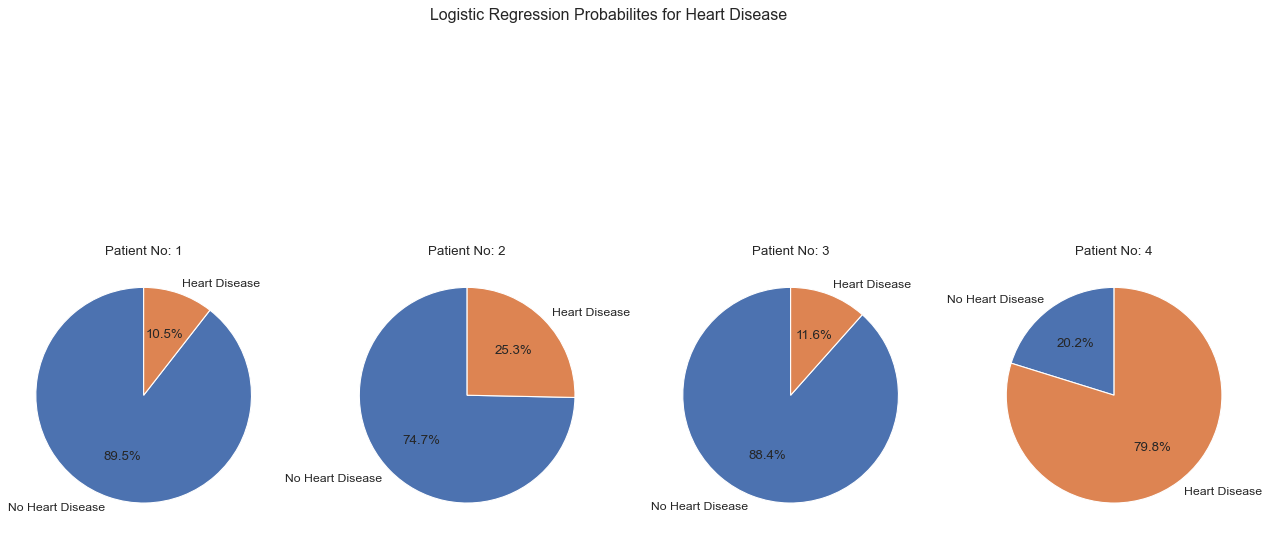

In [47]:
n = 4
prob_n = probs[:(n+1)]

plt.figure(figsize=(20,10), dpi=80)
plt.suptitle("Logistic Regression Probabilites for Heart Disease")
for i in np.arange(1,n+1):
    plt.subplot(1,n,i)
    plt.pie(prob_n[i-1], labels=["No Heart Disease", "Heart Disease"], autopct='%1.1f%%', startangle=90)
    plt.title(f"Patient No: {i}")
plt.show()

Here the probabilities for the first four patients in the dataset is illustrated. Logistic Regression in this case is much more transparent than SVM.

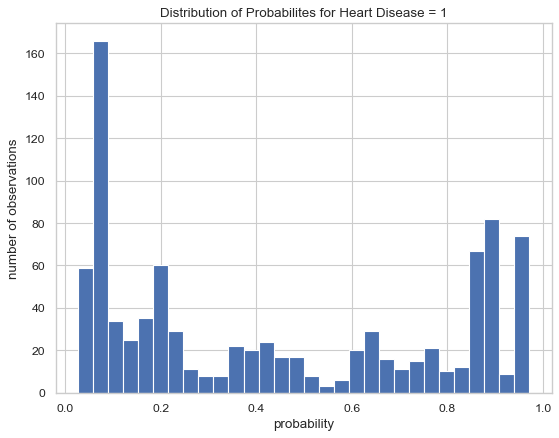

In [48]:
plt.figure(figsize=(8,6),dpi=80)
plt.hist(probs_HD,30)
plt.title("Distribution of Probabilites for Heart Disease = 1")
plt.xlabel("probability")
plt.ylabel("number of observations")
plt.show()

Here we can see that even though for most observation the Logistic Regression model is certain about its prediction, there is still a good amount of patients where the model is unsure (0.4 <= probability <= 0.6). So Logistic Regression can be really helpful in getting insight how certain it is in its predition. 

**Biases**

For potential biases we take a closer look at the features and their occurances in the dataset.

**Gender**: As shown in the EDA section something worth mentioning is that the gender representation in the dataset is highly imbalanced which can be one source of bias. Maybe heart diseases have a fundamentally different cause for men than for women. In that case any model trained on this unbalanced dataset would be useless. 

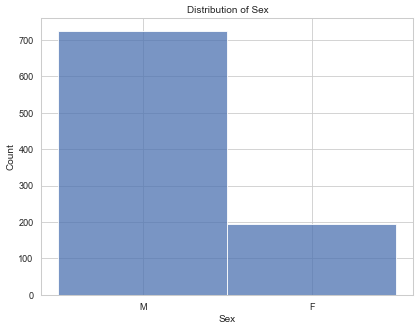

In [49]:
data = pd.read_csv("heart.csv",header=0)
plt.figure(figsize=(8,6),dpi=60)
sns.histplot(data['Sex'])
plt.title("Distribution of Sex")
plt.show()

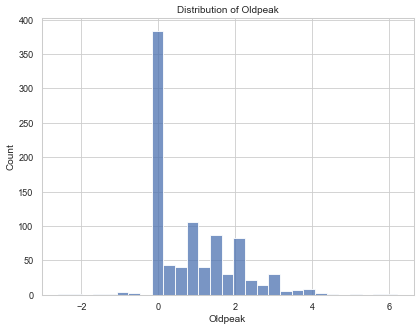

Oldpeak ranges from -2.6 and 6.2
Number of patients with Oldpeak = 0: 368


In [50]:
plt.figure(figsize=(8,6),dpi=60)
sns.histplot(data['Oldpeak'])
plt.title("Distribution of Oldpeak")
plt.show()
print(f"Oldpeak ranges from {min(data['Oldpeak'])} and {max(data['Oldpeak'])}")
print(f"Number of patients with Oldpeak = 0: {data[data['Oldpeak']==0].shape[0]}")

**Oldpeak**: Moreover 368 out of 918 were diagnosed with Oldpeak = 0. I am lacking domain knowlegde to interpret the meaning of that but given that oldpeak ranges from -2.6 and 6.2 it seems suspicious that most patients were diagnosed with Oldpeak = 0. That might be another source of bias which might downstream from the dataset to the predictive model.

**Selection Bias**: A closer look into the dataset reveills that the data consists of 5 different datasets, i.e. 

- Cleveland: 303 observations
- Hungarian: 294 observations
- Switzerland: 123 observations
- Long Beach VA: 200 observations
- Stalog (Heart) Data Set: 270 observations  

The kaggle page where I found this dataset claims that this "makes it the largest heart disease dataset available so far for research purposes" [Fedesoriano]. However that is still a very small dataset to train a sophisticated Machine Learning model. A far bigger training set would be nescessary to overcome potential selection bias and overfitting, as five different regions are not sufficient to ensure generalisability. Unfortunately the dataset does not specify the source dataset for each observation. That could help understand how well/badly the ML model can be transfered to different regions. 

Another form of bias might be embedded in the target variable heart disease. The range of heart diseases is very wide  (e.g. stroke, heart attack, heart failure, etc.) where each single disease has its own cause factors. However this dataset treats all diseases as if they have the same features causing them. The target variable should be more specific. Of course that would require a lot of labled data which might be expensive and hard to obtain due to privacy issues.

**Privacy**

Last but not least working with health related data always raises the question whether privacy is preserved. This dataset contains no personal information about the patients, however, the UCI website states "names and social security numbers of the patients were recently removed" [UCI2]. Does that mean up until *recently* names and social security numbers were part of the dataset? Privacy concerns would clearly be violated by including personal information to publically available datasets. 

<a id='8'></a>
## 8 Sustainable development relevance & impact



This section discusses the current challenges surrounding this dataset in terms of sustainable development and how can ML help overcome them? We also touch on how this model helps achieving the sustainable development goals (SDG) from the 2030 UN [agenda](https://sdgs.un.org/2030agenda).

**Direct SDG**

**SGD 3: Good Health and Well Being**  
Using Machine Learning to predict if somebody is likely to get a heart disease can cleary enable SDG 3. This notebook has shown that a small amount of features (especially ST_Slope, Exercise Angina, Olpeak and ChestPainType) can be sufficient to achieve high performance Machine Learning Models such as SVM with polynomail kernel. Such a model can be used to indicate early signs for a heart disease so doctors can take appropriate measures. Essentially lives can be saved! Additionally the models are very scalable because they only depend on tabular data with a small number of features. Therefore computational concerns are not problematic. More perceicely, target 3.4 is adressed:  

*Target 3.4: by 2030 reduce by one-third pre-mature mortality from non-communicable diseases (NCDs) through prevention and treatment, and promote mental health and wellbeing*  

However interpretability challenges remain and ML models must be used in combination with domain knowledge of experienced doctors and decisions must be adjusted to each individual patient to prevent false negatives (diagnosing no heart disease while patient has one).

**Indirect SDGs**

**SDG 10: Reduced Inequalities**  
According to WHO over 75% of Cardiovascular (heart) disease deaths occur in low or middle-income countries [WHO]. "People living in low- and middle-income countries often do not have the benefit of primary health care programmes for early detection and treatment of people with risk factors for CVDs. " [WHO]. As this ML model requires only basic diagnostics such as heart rate, blood pressure etc. it can help to detect heart diseases in low and middle-income without the necessity of expensive hostipals and doctors. Therefore reduced inequalities between countries in terms of access to health care is achieved. SGD 10 is therefore indirectly achieved by addressing target 3.b from SDG 3:  

*Target 3.d: strengthen the capacity of all countries, particularly developing countries, for early warning, risk reduction, and management of national and global health risks*  

Since I am not an expert in the heart disease domain, I am unsure though what medical infrastructure is necessary to take the measurements of the features. Policy makers have to ensure that less developed regions have the same access to resources to apply the ML model. Otherwise the Machine Learning model only improves the health status of already better equipped regions which could potnetially lead to a negative effect on SDG 10: Reduced Inequalities. 

**SDG 8: Decent Work and Economic Growth**  
"At the household level, evidence is emerging that CVDs and other noncommunicable diseases contribute to poverty due to catastrophic health spending and high out-of-pocket expenditure. At the macro-economic level, CVDs place a heavy burden on the economies of low- and middle-income countries" [WHO]. "As a result, for many people in these countries detection is often late in the course of the disease and people die at a younger age from CVDs and other noncommunicable diseases, often in their most productive years" [WHO]. Consequently, if a ML model can help reduce the occurance of unexpected heart diseases in low and middle-income countries then economies can grow because of less health related interruptions. 

**Limitations**  

As stated in [Alotaibi], the main limitation of the ML model is the size of the dataset. Much more data from a wider range of regions is needed to predict more reliably and reduce the risk of overfitting. Of course to enable larger datasets politics is involved to make countries collaborate on a standard of diagnostics and a standard to ensure anominization such that privacy is preserved. 

Another one is that by predicting a heart disease patients are not automatically cured. It requires a lot medical infrastructure to take appropriate measures to help prevent a heart disease. "Sometimes, surgical operations are required to treat CVDs" [WHO]. Therefore indicating the likeliness of a heart disease is only the first step. Significant investments in the strengthening of health systems especially in lower income countries is required to actually reduce the risk of heart diseases.

<a id='9'></a>
## 9 References

*last accessed: December 19th 2022*



- [Bashir] Bashir, Saba, et al. ["Improving heart disease prediction using feature selection approaches."](https://ieeexplore.ieee.org/document/8667106) 2019 16th international bhurban conference on applied sciences and technology (IBCAST). IEEE, 2019.
- [Ekız] Ekız, Simge, and Pakize Erdoğmuş. ["Comparative study of heart disease classification."](https://ieeexplore.ieee.org/abstract/document/7956761) 2017 Electric Electronics, Computer Science, Biomedical Engineerings' Meeting (EBBT). IEEE, 2017.
- [Alotaibi] Alotaibi, Fahd Saleh. ["Implementation of machine learning model to predict heart failure disease."](https://thesai.org/Publications/ViewPaper?Volume=10&Issue=6&Code=IJACSA&SerialNo=37) International Journal of Advanced Computer Science and Applications 10.6 (2019).
- [WHO] https://www.who.int/en/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)
- [Fedesoriano] fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.
- [ohseokkim] https://www.kaggle.com/code/ohseokkim/heart-disease-could-our-model-save-lives
- [tanmay111999] https://www.kaggle.com/code/tanmay111999/heart-failure-prediction-cv-score-90-5-models
- [UCI1] https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/
- [UCI2] https://archive.ics.uci.edu/ml/datasets/heart+disease
- [towardsdatascience] https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9